#**Semantic Segmentation**

**`Semantic Segmentation`**: Use a neural network to perform semantic segmentation on the RGB images. You can initially use a pre-trained network, but it is also recommended that you fine-tune using your own data, just like in the first task. Similarly, you can add the depth image as an extra feature either as an input channel, or as an input to the last layer (note: this is considerably easier to do here than in the first case).

# Importing Libraries

In [ ]:
import numpy as np
import cv2
import keras
import tensorflow as tf

# from tensorflow.keras import layers
from matplotlib import pyplot as plt


from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,BatchNormalization,Activation,Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
from keras import regularizers
from keras.callbacks import TensorBoard,EarlyStopping


In [ ]:
import cv2
import matplotlib

# One hot encoding , and other functions






One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

reverse one hot encoding ensures that each pixel is represented by a class label rather than rgb color code.

Color code segmentation to recolor the predicted images 

In [ ]:
def one_hot_it(label, label_values): 

    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x


def colour_code_segmentation(image, label_values):

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

**Labels defined**

In [ ]:
COLORS = [
        [0, 0, 0], [70, 70, 70], [100, 40, 40], [55, 90, 80], [220, 20, 60],
        [153, 153, 153], [157, 234, 50], [128, 64, 128], [244, 35, 232], [107, 142, 35],
        [0, 0, 142], [102, 102, 156], [220, 220, 0] ]
    

Classes = [
'unlabelled', 'building', 'fence', 'other', 'pedestrian',
'pole', 'Road Lines', 'Road', 'side walk', 'vegetation',
'vehicle', 'wall', 'trafficsign']

In [ ]:
n_classes = 13

#Loading data 

reading and iterating through the dataset 

In [ ]:
rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/3rd Task Semantic_Seg/train_X'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/3rd Task Semantic_Seg/train_Y'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

In [ ]:
num_images = 40
images=[]
annotations=[]
classnames,label_values = Classes,COLORS
for i in range(num_images):
    img1,label_img= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])
    img1=cv2.resize(img1,(256,256))

    label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
    mask1 = np.float32(one_hot_it(label_img, label_values))
    mask1 = cv2.resize(mask1,(256,256))
    mask1 = reverse_one_hot(mask1)

    
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)


In [ ]:
annotations[1]

array([[ 0,  0,  0, ..., 11, 11, 11],
       [ 0,  0,  0, ..., 11, 11, 11],
       [ 0,  0,  0, ..., 11, 11, 11],
       ...,
       [ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  7,  7,  7]])

In [ ]:
annotations.shape

(40, 256, 256)

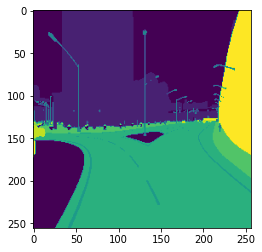

In [ ]:
plt.imshow(annotations[1])

Shuffling **Images**

In [ ]:
import random
shuffle_images = num_images

val_samples =int(num_images*0.2)
random.Random(shuffle_images).shuffle(images)
random.Random(shuffle_images).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]



```
# This is formatted as code
```

#UNET Model defined and displayed

# **UNET Model defined**

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler)

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model  

model summary

In [ ]:

model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

#Training the network

Here I compile and train the model to do the semantic segmentation. Sparse Categorical crossentropy is used as a loss function because the network assigns a label to each pixel . So the network is trying to predict the class and for this sparse categorical cross entorpy is the ideal loss function.

In [ ]:
model = Unet(256,256,nclasses = 13, filters =64)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/weights2.h5', monitor='accuracy', save_best_only='True', save_weights_only='False', verbose=1)
es = EarlyStopping(mode='max', monitor='accuracy', patience=8, verbose=1)
callbacks = [tb, mc, es]

In [ ]:
history = model.fit(images,annotations, batch_size=32, epochs=100, callbacks=callbacks, workers=8,validation_split = 0.2, shuffle=True)

Epoch 1/100


# Evaluating the model

Loading the model

In [48]:
from keras.models import load_model

unet = Unet(256, 256, nclasses=13, filters=64)
unet_l = unet.load_weights('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/weights2.h5')

#Evaluating metrics

**F1 score**

As we know Semantic segmentation is infact just per pixel classification problem . pixel match accuracy is a very poor metric so we instead use f1 score to evaluate our model

image.png

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [ ]:

def seg_metrics(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):

    
    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')
    
    # always assume one or more classes
    num_classes = K.shape(y_true)[-1]
        
    if not flag_soft:
        # get one-hot encoded masks from y_pred (true masks should already be one-hot)
        y_pred = K.one_hot(K.argmax(y_pred), num_classes)
        y_true = K.one_hot(K.argmax(y_true), num_classes)

    # if already one-hot, could have skipped above command
    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')
    
    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]
    
    if verbose:
        print('intersection, union')
        print(K.eval(intersection), K.eval(union))
        print(K.eval(intersection/union))
    
    # return mean metrics: remaining axes are (batch, classes)
    if flag_naive_mean:
        return K.mean(metric)

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)
    
    if verbose:
        print('Counts of inputs with class present, metrics for non-absent classes')
        print(K.eval(class_count), K.eval(non_zero_sum / non_zero_count))
        
    return K.mean(non_zero_sum / non_zero_count)

def mean_iou(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='dice', **kwargs)

source :https://github.com/quantumjot/unet_segmentation_metrics
for miou 

#loading the test dataset

In [ ]:
gt_dir='//content/drive/MyDrive/Colab Notebooks/Test_Segmentation/3rd Task Semantic_Seg/test_Y'

gt_path = list(sorted([ os.path.join(gt_dir, fname) for fname in os.listdir(gt_dir) ]))

X_dir='//content/drive/MyDrive/Colab Notebooks/Test_Segmentation/3rd Task Semantic_Seg/test_X'

X_path = list(sorted([ os.path.join(X_dir, fname) for fname in os.listdir(X_dir) ]))

In [ ]:
import random
num_images = 130
images_test=[]
annotations_test=[]
classnames,label_values = Classes,COLORS
for i in range(num_images):
    img1,label_img= cv2.imread(X_path[i]),cv2.imread(gt_path[i])
    img1=cv2.resize(img1,(256,256))

    label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
    mask1 = np.float32(one_hot_it(label_img, label_values))
    mask1 = cv2.resize(mask1,(256,256))
    # mask1 = reverse_one_hot(mask1)

    
    images_test.append(img1)
    annotations_test.append(mask1)
images_test=np.array(images_test)
annotations_test=np.array(annotations_test)

In [68]:
ground_truth=[]
for i in range(num_images):
  gt_img =cv2.imread(gt_path[i])
  gt_img= cv2.cvtColor(gt_img,cv2.COLOR_BGR2RGB)
  gt_img = cv2.resize(gt_img,(256,256))
  ground_truth.append(gt_img)

In [110]:
pred_img=[]

for i in range(num_images):
  imgs_test = np.expand_dims(images_test[i],axis=0)
  imgs_mask_test = unet.predict(imgs_test)

  newimg = np.zeros((256,256))
  #print(pred)
  for i in range(13):
      for j in range(256):
          for k in range(256):
              if imgs_mask_test[0,j,k,i] > 0.4:
                newimg[j,k] = i
  pred = colour_code_segmentation(newimg, COLORS)
  pred_img.append(pred)

#**Visualize the Results**

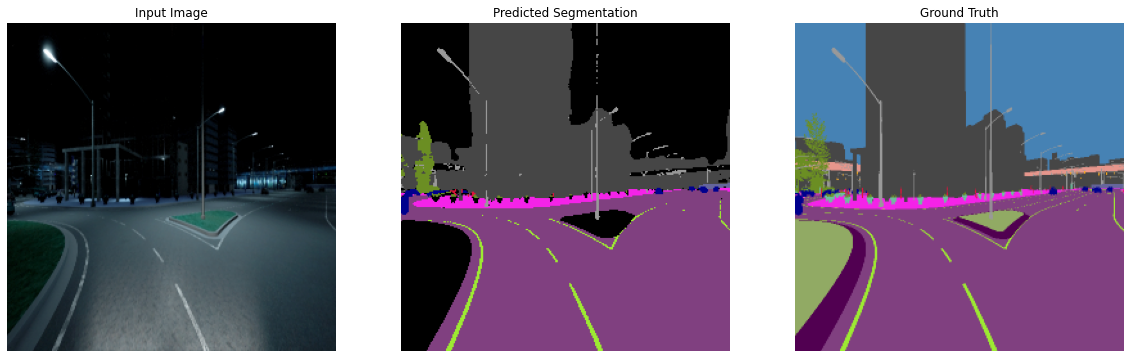

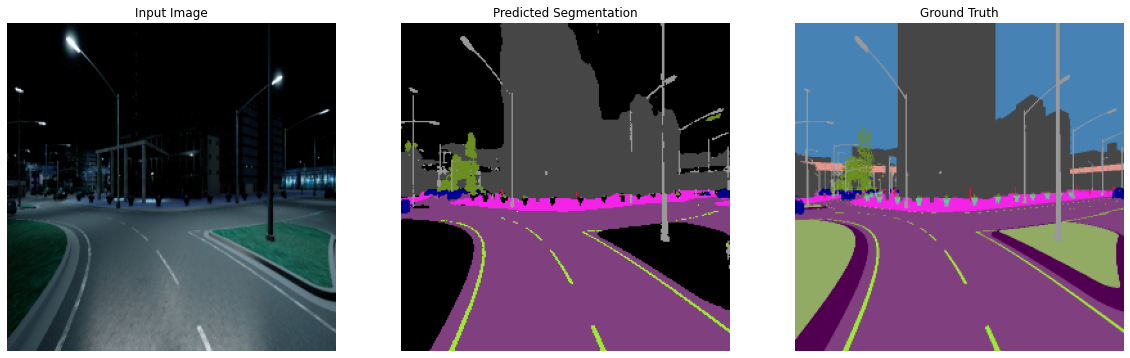

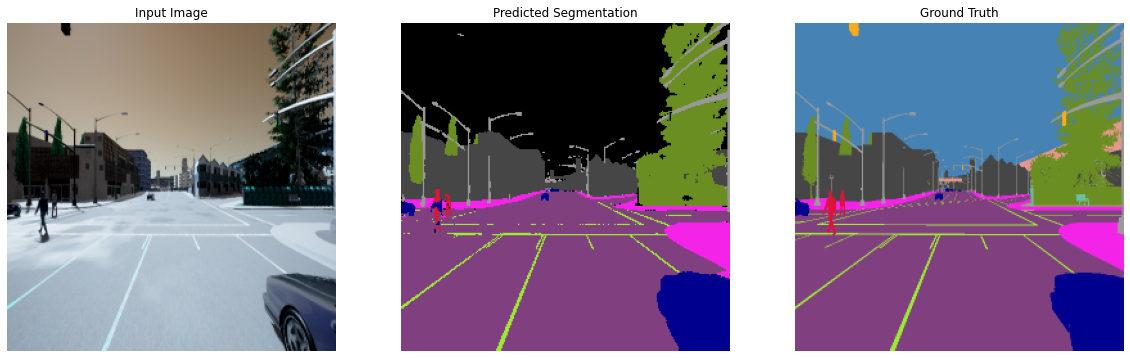

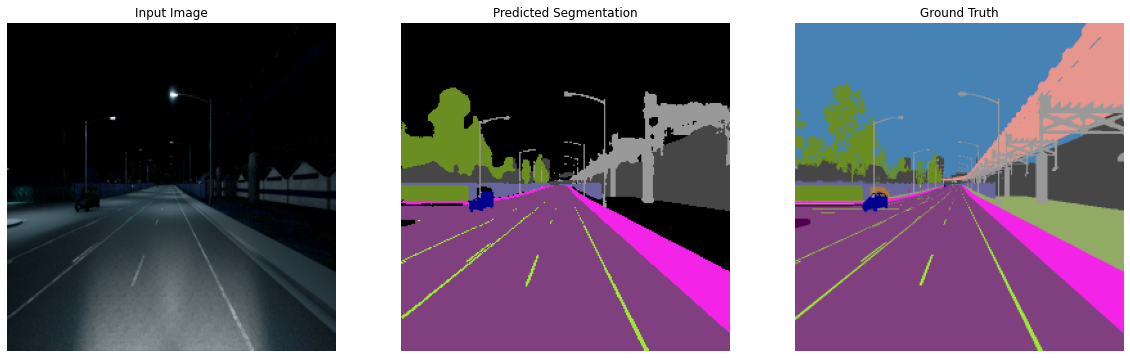

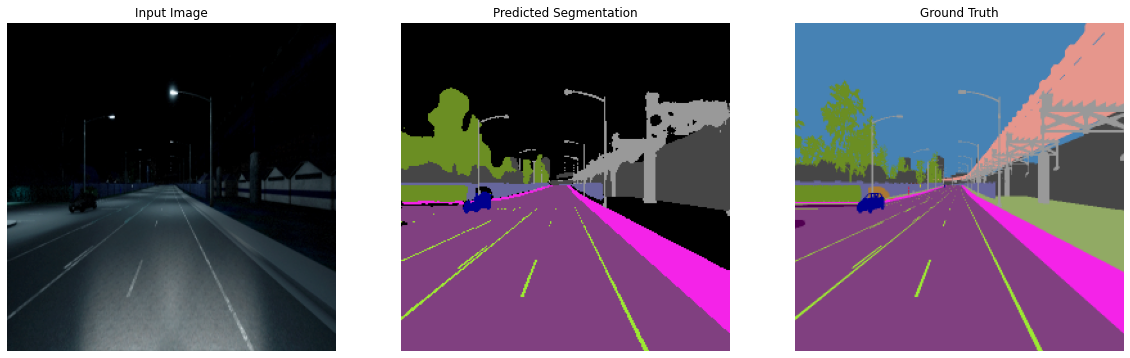

In [112]:
Lis = [10,30,50,70,90]

for i in range (5):

  figure = plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  plt.axis('off')
  plt.imshow(images_test[i])
  plt.subplot(1, 3, 2)
  plt.title('Predicted Segmentation')
  plt.axis('off')
  plt.imshow(pred_img[i])
  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(ground_truth[i])
  plt.show()

#Testing the efficiency of the system

**f1_score**

In [ ]:
f1_score(annotations_test,predicted)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7913868>

**mean_dice**

In [ ]:
mean_dice(annotations_test,predicted,metric_type='standard', mean_per_class=False)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73361933>

**miou**

In [ ]:
print(aa) 

tf.Tensor(0.6687521, shape=(), dtype=float32)
